**This notebook trains a 3-layer neural network on a credit-risk dataset.**


In [497]:
# Data preprocessing guide: https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/
# Dataset from: https://www.kaggle.com/datasets/laotse/credit-risk-dataset/data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [498]:
df = pd.read_csv("credit_risk_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [499]:
df = df.dropna() # drop null values
df = df.drop_duplicates() # drop duplicates

# one hot encoding for String values
df = pd.get_dummies(df, columns=['person_home_ownership',], dtype=np.uint8)
df = pd.get_dummies(df, columns=['loan_intent',], dtype=np.uint8)
df = pd.get_dummies(df, columns=['loan_grade',], dtype=np.uint8)
df = pd.get_dummies(df, columns=['cb_person_default_on_file',], dtype=np.uint8)

df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,0,0,...,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,1,0,...,0,0,0,1,0,0,0,0,1,0
32577,54,120000,4.0,17625,7.49,0,0.15,19,1,0,...,0,1,0,0,0,0,0,0,1,0
32578,65,76000,3.0,35000,10.99,1,0.46,28,0,0,...,0,0,1,0,0,0,0,0,1,0
32579,56,150000,5.0,15000,11.48,0,0.10,26,1,0,...,0,0,1,0,0,0,0,0,1,0


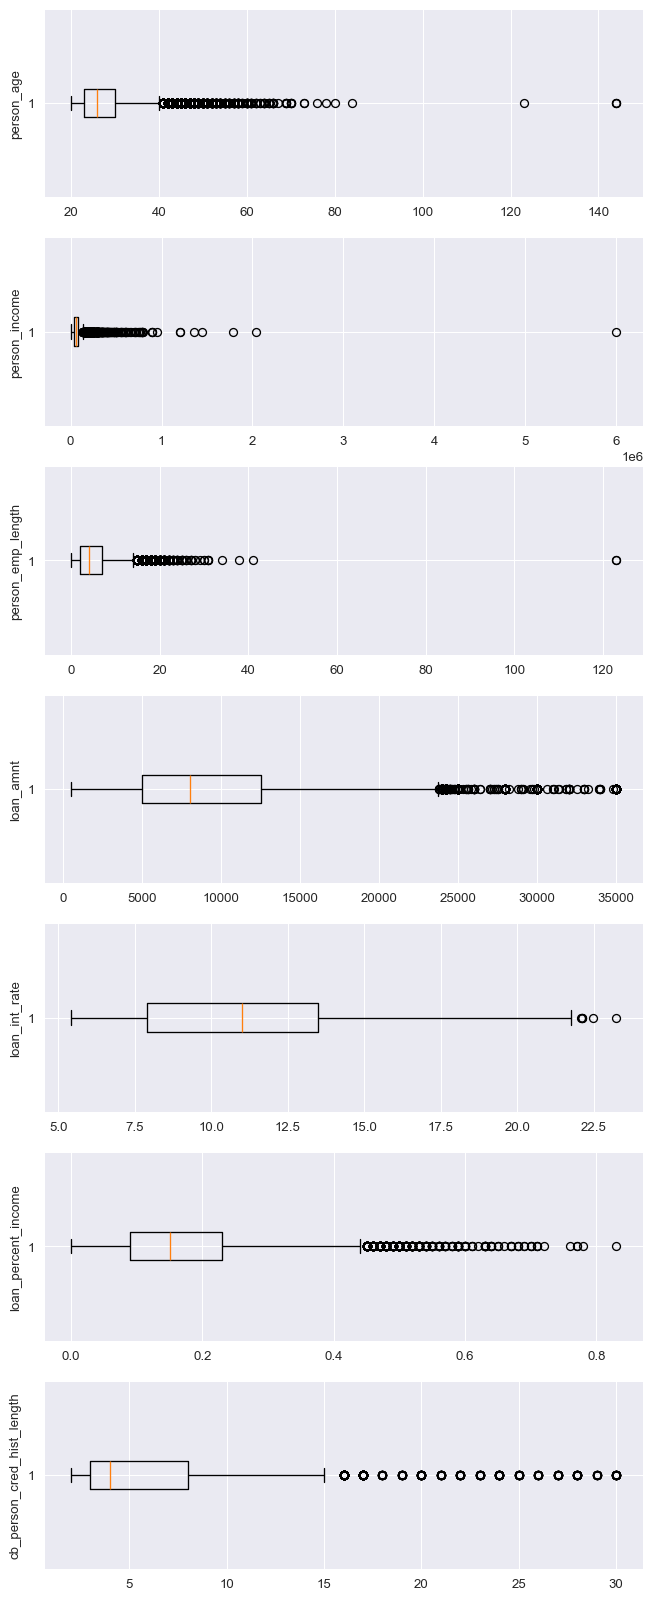

In [500]:
# Visually see outliers
fig, axs = plt.subplots(7, 1, dpi=95, figsize=(7,17))
fig.tight_layout()
i = 0
for col in df.iloc[:, :8]: # show only first 8 columns of data. the rest of the data are hot-encoded
    if str(col) == 'loan_status': # skip loan status
        continue
    axs[i].boxplot(df[col], vert=False)
    axs[i].set_ylabel(col)
    i += 1
plt.show()

In [501]:
for col in df.iloc[:, :8]:
    if str(col) == 'loan_status': # skip loan status
        continue 
    # Identify the quartiles
    q1, q3 = np.percentile(df[col], [25, 75])
    # Calculate the interquartile range
    iqr = q3 - q1
    # Calculate the lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    # Drop the outliers
    df = df[(df[col] >= lower_bound)
                    & (df[col] <= upper_bound)]


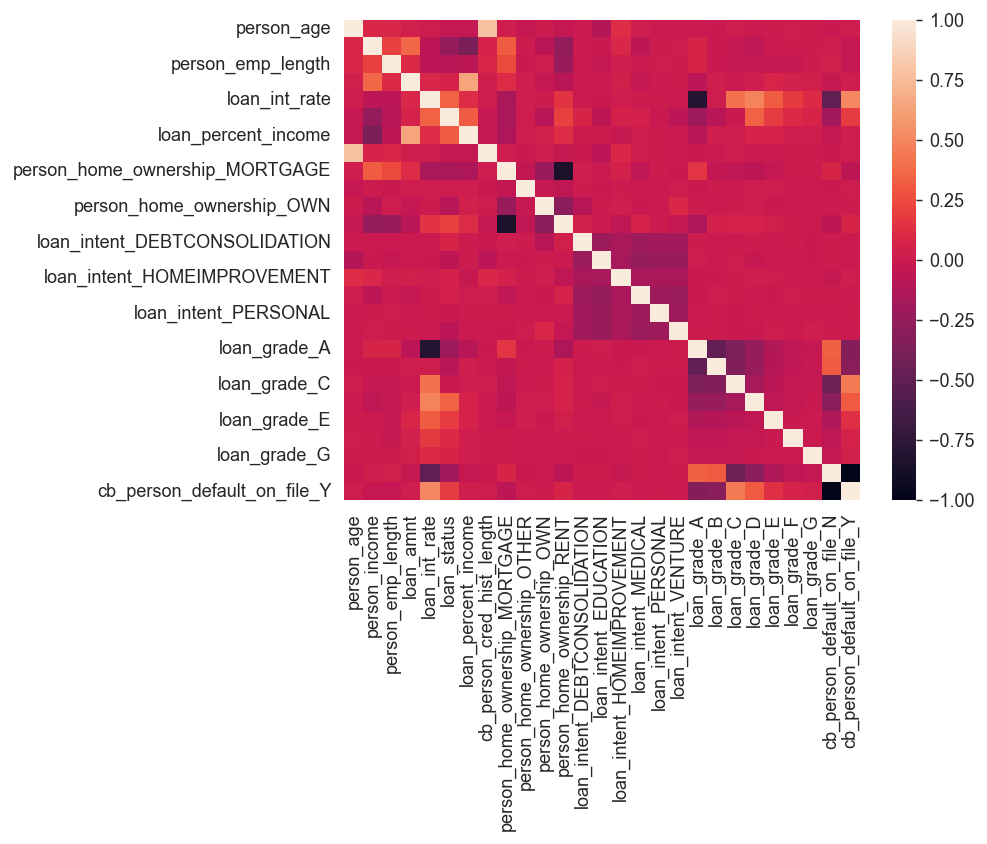

In [502]:
# visualize correlation
corr = df.corr()
plt.figure(dpi=130)
sns.heatmap(corr)
plt.show()


<Axes: xlabel='loan_status'>

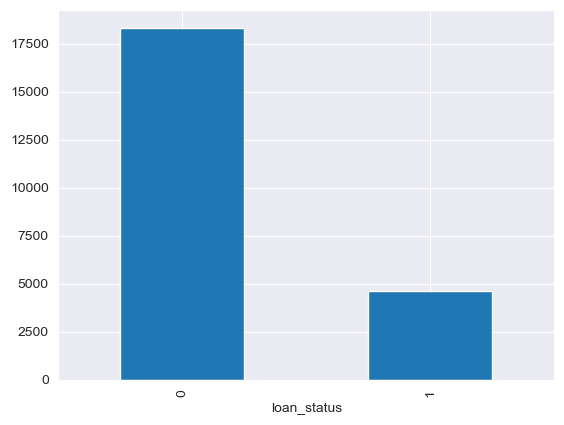

In [503]:
# See how many data examples of default/non-default
df['loan_status'].value_counts().plot(kind='bar')

In [504]:
# Standardization of data values
for col in df.iloc[:, :8]:
    if str(col) == 'loan_status': # skip loan status
        continue
    df[col] = (df[col] - df[col].mean()) / df[col].std() # standardization of value

In [505]:
# Under-sampling the data to achieve balance between the outputs
number_default = df['loan_status'].value_counts()[1] # get the number of defaults
non_default_indices = df[df['loan_status'] == 0].index # indices of all data samples where loan status is non-default
random_indices = np.random.choice(non_default_indices, number_default, replace=False) # random indices of non-default matching the number of default samples
non_default_sample = df.loc[random_indices] # get the randomly sampled dataframe where loan status is non-default
default_sample = df[df['loan_status'] == 1]
X = pd.concat([non_default_sample, default_sample], ignore_index=True) # append the dataframes together. 

X = X.sample(frac=1) # sort to prevent model from overfitting to data of one type
X

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
8039,0.454953,-0.970105,-0.401316,-0.724177,0.996841,1,-0.104450,0.800299,0,0,...,0,0,0,0,1,0,0,0,1,0
2046,-1.309262,-0.683941,0.192433,-0.082496,-0.215859,0,0.454651,-0.307429,1,0,...,0,0,1,0,0,0,0,0,1,0
3291,-0.301139,0.371057,1.083055,-0.496484,0.464130,0,-0.775372,-0.307429,0,0,...,0,0,1,0,0,0,0,0,1,0
6903,-1.057231,-0.938083,-1.291938,-1.158864,1.466880,1,-0.887192,-0.676671,0,0,...,0,0,0,0,1,0,0,0,0,1
4614,-1.309262,-1.817750,-0.698190,-1.220962,-1.190406,1,1.013752,-1.045914,0,0,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7468,-1.057231,0.615028,0.489307,-0.703478,-0.767371,1,-0.999012,-1.045914,1,0,...,0,1,0,0,0,0,0,0,1,0
3788,0.706983,0.371207,-0.698190,-1.220962,0.642745,0,-1.334473,1.538785,0,0,...,0,0,0,1,0,0,0,0,0,1
2249,-0.805200,0.446252,-0.104441,-0.910471,-0.920917,0,-1.110832,-1.045914,1,0,...,1,1,0,0,0,0,0,0,1,0
7181,-1.309262,0.408730,-1.291938,1.366461,1.360338,1,0.678291,-0.307429,0,0,...,0,0,0,0,1,0,0,0,0,1


<Axes: xlabel='loan_status'>

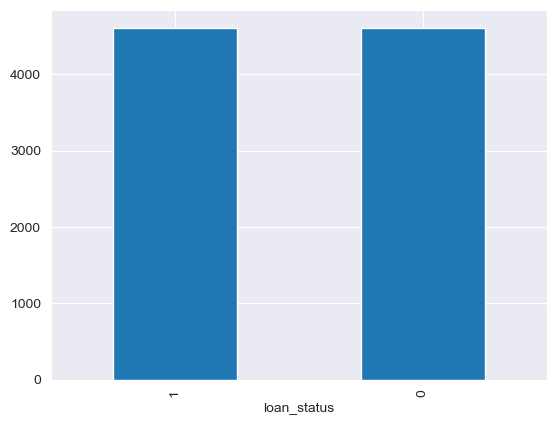

In [506]:
# See how many data examples of default/non-default
X['loan_status'].value_counts().plot(kind='bar')

In [507]:
def train_test_split(df, frac=0.1):
    test = df.sample(frac=frac, axis=0)
    train = df.drop(index=test.index)
    return train, test

# Split dataframe into train and test
train, test = train_test_split(X)

Y = train['loan_status']
X = train.drop('loan_status', axis=1)

In [533]:
testY = test['loan_status']
testX = test.drop('loan_status', axis=1)
print(testX.shape)
print(testY.shape)

(923, 27)
(923, 26)
(923,)


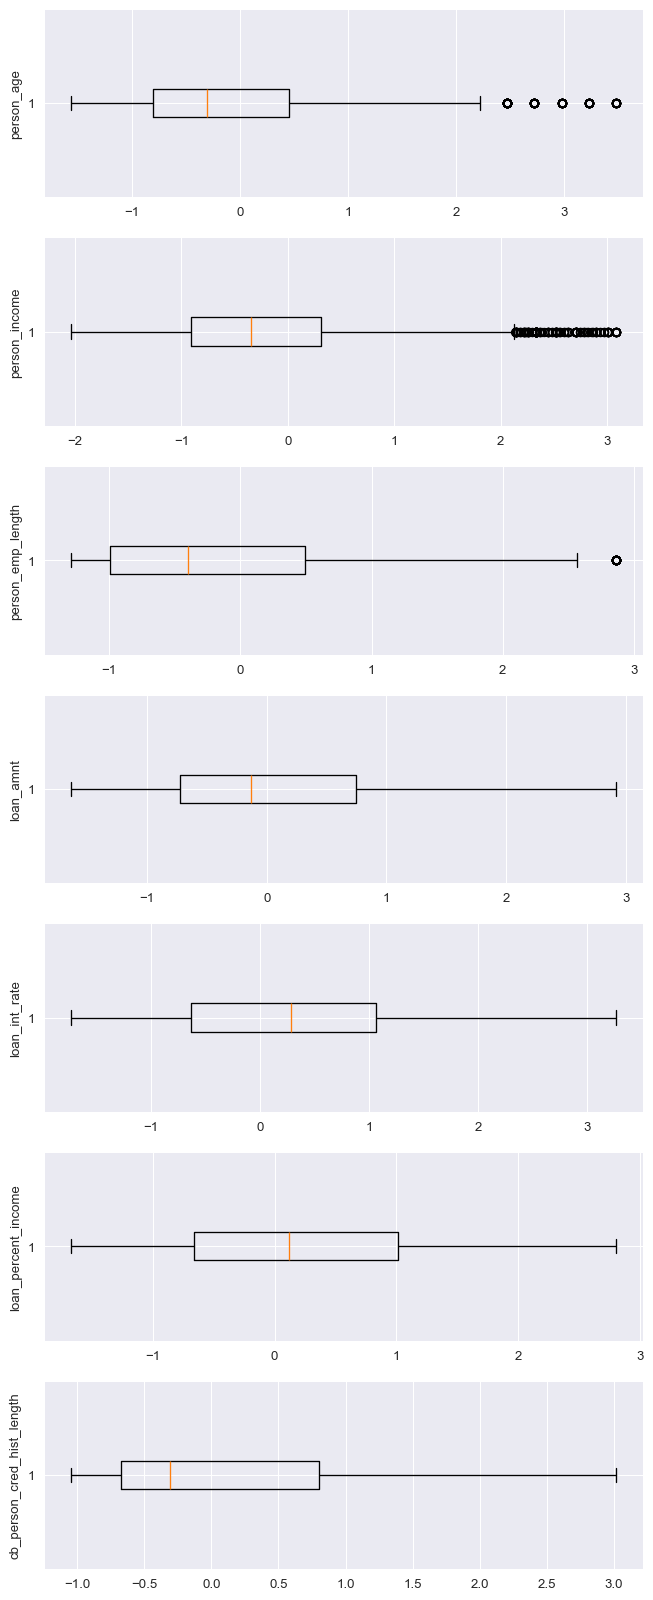

In [508]:
# Check distribution of data
fig, axs = plt.subplots(7, 1, dpi=95, figsize=(7,17))
fig.tight_layout()
i = 0
for col in X.iloc[:, :7]: # show only first 7 columns of data. the rest of the data are hot-encoded
    axs[i].boxplot(X[col], vert=False)
    axs[i].set_ylabel(col)
    i += 1
plt.show()

In [509]:
# Code for neural network. Adapted from: https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras

In [510]:
X = X.to_numpy()
Y = Y.to_numpy()

In [511]:
Y = np.reshape(Y, (-1, 1)) # reshape from 1D to 2D

print(X.shape)
print(Y.shape)

(8305, 26)
(8305, 1)


In [536]:
testY = np.reshape(testY, (-1, 1)) # reshape from 1D to 2D
print(testY.shape)

testX = testX.T

(923, 1)


In [512]:
X = X.T
M = X.shape[1]

In [513]:
nZ1 = 256 # number of nodes in hidden layer Z1
nZ2 = 256 # number of nodes in Z2

In [514]:
def init_params():
    W1 = np.random.rand(nZ1, X.shape[0]) - 0.5
    W2 = np.random.rand(nZ2, nZ1) - 0.5
    W3 = np.random.rand(Y.shape[1], nZ2) - 0.5
    b1 = np.random.rand(nZ1, 1) - 0.5
    b2 = np.random.rand(nZ2, 1) - 0.5
    b3 = np.random.rand(Y.shape[1], 1) - 0.5

    return W1, b1, W2, b2, W3, b3

In [515]:
leakyReLUConstant = 0.01

def leakyReLU(X):
    return np.maximum(leakyReLUConstant * X, X)

def derivativeLeakyReLU(X):
    return np.where(X > 0, 1, leakyReLUConstant)

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def derivativeSigmoid(X):
    return X * (1 - X)

In [516]:
def forward(X, W1, W2, W3, b1, b2, b3):
    Z1 = W1.dot(X) + b1
    A1 = leakyReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = leakyReLU(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = sigmoid(Z3)

    return Z1, A1, Z2, A2, Z3, A3


In [517]:
def backwardProp(X, Y, W2, W3, Z1, A1, Z2, A2, Z3, A3):
    dZ3 = (A3 - Y.T)
    dW3 = 1/M * dZ3.dot(A2.T)
    db3 = 1/M * np.sum(dZ3)
    dZ2 = derivativeLeakyReLU(Z2) * W3.T.dot(dZ3)
    dW2 = 1/M * dZ2.dot(A1.T)
    db2 = 1/M * np.sum(dZ2)
    dZ1 = derivativeLeakyReLU(Z1) * W2.T.dot(dZ2)
    dW1 = 1/M * dZ1.dot(X.T)
    db1 = 1/M * np.sum(dZ1)

    return dW3, db3, dW2, db2, dW1, db1

In [518]:
def update_params(alpha, W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1

    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2

    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3

    return W1, b1, W2, b2, W3, b3

In [561]:
def get_predictions(A3):
    return np.where(A3 > 0.5, 1, 0)

def get_accuracy(predictions, Y, size):
    return np.sum(predictions == Y) / size

In [566]:
def learn(X, Y, alpha, iter):
    W1, b1, W2, b2, W3, b3 = init_params()
    for i in range(iter):
        Z1, A1, Z2, A2, Z3, A3 = forward(X, W1, W2, W3, b1, b2, b3)
        dW3, db3, dW2, db2, dW1, db1 = backwardProp(X, Y, W2, W3, Z1, A1, Z2, A2, Z3, A3)
        W1, b1, W2, b2, W3, b3 = update_params(alpha, W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3)
        if i % 10 == 0:
            print("Iteration", i)
            predictions = get_predictions(A3)
            print(A3)
            print(Y.T)
            print(predictions)
            print(get_accuracy(predictions, Y.T, M))
    return W1, b1, W2, b2, W3, b3

In [564]:
def testPrediction(testX, W1, W2, W3, b1, b2, b3):
    Z1, A1, Z2, A2, Z3, A3 = forward(testX, W1, W2, W3, b1, b2, b3)
    predictions = get_predictions(A3)
    print(predictions[0][:10])
    return get_accuracy(predictions, testY.T, testY.shape[0])

In [543]:
W1, b1, W2, b2, W3, b3 = learn(X, Y, 0.1, 10000)


Iteration 0
[[6.90523108e-06 3.76977942e-03 6.27428032e-06 ... 6.91460716e-04
  2.38011444e-02 1.34620657e-02]]
[[1 0 0 ... 0 1 0]]
[[0 0 0 ... 0 0 0]]
0.4947621914509332
Iteration 10
[[0.44834254 0.45008497 0.45121507 ... 0.42985577 0.57560862 0.44952928]]
[[1 0 0 ... 0 1 0]]
[[0 0 0 ... 0 1 0]]
0.5743527995183624
Iteration 20
[[0.46031776 0.45363016 0.45501478 ... 0.43408806 0.69137566 0.45517217]]
[[1 0 0 ... 0 1 0]]
[[0 0 0 ... 0 1 0]]
0.6228777844671884
Iteration 30
[[0.46743877 0.43756771 0.43537349 ... 0.42577636 0.82156648 0.4598159 ]]
[[1 0 0 ... 0 1 0]]
[[0 0 0 ... 0 1 0]]
0.6776640577965082
Iteration 40
[[0.4550262  0.41356046 0.39446623 ... 0.40058173 0.88807637 0.45558321]]
[[1 0 0 ... 0 1 0]]
[[0 0 0 ... 0 1 0]]
0.7089704996989765
Iteration 50
[[0.44921645 0.38958235 0.35524203 ... 0.3667333  0.91311426 0.43693377]]
[[1 0 0 ... 0 1 0]]
[[0 0 0 ... 0 1 0]]
0.7278747742323901
Iteration 60
[[0.46133354 0.36312929 0.31138518 ... 0.32708829 0.93052388 0.41296589]]
[[1 0 0 ... 

In [565]:
# print(testX[:10])
print(testY.T[0][:10])
print(testPrediction(testX, W1, W2, W3, b1, b2, b3))

[0 1 1 1 0 0 0 0 1 0]
[0 1 1 0 0 0 1 0 0 0]
0.7952329360780065
